In [1]:
import time, math, itertools, random
import matplotlib.pyplot as plt
from collections import defaultdict
print("Setup done. matplotlib version:", plt.matplotlib.__version__)


Setup done. matplotlib version: 3.10.0


In [2]:

locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

print("Locations:", locations)
print("Distance matrix:")
for row in distance_matrix:
    print(row)
print("Parcels:", parcels)
print("Capacity:", vehicle_capacity)


Locations: ['Warehouse', 'C1', 'C2', 'C3']
Distance matrix:
[0, 4, 8, 6]
[4, 0, 5, 7]
[8, 5, 0, 3]
[6, 7, 3, 0]
Parcels: {'C1': {'value': 50, 'time': (9, 12), 'weight': 10}, 'C2': {'value': 60, 'time': (10, 13), 'weight': 20}, 'C3': {'value': 40, 'time': (11, 14), 'weight': 15}}
Capacity: 30


In [3]:

from functools import lru_cache

n = len(locations)
@lru_cache(None)
def delivery_cost(pos, visited_mask):
    if visited_mask == (1 << (n-1)) - 1:
        return distance_matrix[pos][0]
    best = float('inf')
    for j in range(1, n):
        bit = 1 << (j-1)
        if not (visited_mask & bit):
            cost = distance_matrix[pos][j] + delivery_cost(j, visited_mask | bit)
            if cost < best:
                best = cost
    return best

recurrence_cost = delivery_cost(0, 0)
print("Recurrence minimal travel (returning to warehouse):", recurrence_cost)


Recurrence minimal travel (returning to warehouse): 18


In [4]:

def greedy_select(parcels, capacity):
    items = []
    for loc, info in parcels.items():
        items.append((loc, info['value'], info['weight'], info['value']/info['weight']))
    items.sort(key=lambda x: x[3], reverse=True)
    chosen = []; total_weight = 0; total_value = 0
    for loc, val, w, ratio in items:
        if total_weight + w <= capacity:
            chosen.append(loc); total_weight += w; total_value += val
    return chosen, total_value, total_weight

chosen, val_sum, wt_sum = greedy_select(parcels, vehicle_capacity)
print("Greedy chosen parcels:", chosen, "Total value:", val_sum, "Total weight:", wt_sum)


Greedy chosen parcels: ['C1', 'C2'] Total value: 110 Total weight: 30


In [5]:

def feasible_route_time(order_indices, start_time=9):
    t = start_time; pos = 0
    for idx in order_indices:
        t += distance_matrix[pos][idx]
        earliest, latest = parcels[locations[idx]]['time']
        if t > latest:
            return False
        if t < earliest:
            t = earliest
        pos = idx
    return True

order = [1,2,3]
print("Order", [locations[i] for i in order], "feasible?", feasible_route_time(order, start_time=8))


Order ['C1', 'C2', 'C3'] feasible? False


In [6]:

import heapq
def dijkstra(dist_mat, src=0):
    n = len(dist_mat); dist = [float('inf')]*n; dist[src]=0; pq=[(0,src)]; parent=[-1]*n
    while pq:
        d,u = heapq.heappop(pq)
        if d>dist[u]: continue
        for v in range(n):
            w = dist_mat[u][v]
            if w>0 and dist[v] > dist[u] + w:
                dist[v] = dist[u] + w; parent[v]=u; heapq.heappush(pq,(dist[v],v))
    return dist, parent

dist_from_warehouse, parent = dijkstra(distance_matrix, 0)
print("Shortest distances from warehouse:", dist_from_warehouse)

def prim_mst(dist_mat):
    n = len(dist_mat); in_mst=[False]*n; key=[float('inf')]*n; parent=[-1]*n; key[0]=0
    for _ in range(n):
        u = min((key[i], i) for i in range(n) if not in_mst[i])[1]
        in_mst[u]=True
        for v in range(n):
            w = dist_mat[u][v]
            if w>0 and not in_mst[v] and w < key[v]:
                key[v]=w; parent[v]=u
    edges=[]; total=0
    for i in range(1,n):
        edges.append((parent[i], i, dist_mat[parent[i]][i])); total += dist_mat[parent[i]][i]
    return edges, total

mst_edges, mst_cost = prim_mst(distance_matrix)
print("MST edges:", mst_edges, "cost:", mst_cost)


Shortest distances from warehouse: [0, 4, 8, 6]
MST edges: [(0, 1, 4), (1, 2, 5), (2, 3, 3)] cost: 12


In [7]:

from itertools import permutations
def tsp_bruteforce(locations, dist_mat):
    n = len(locations); indices = list(range(1,n)); min_cost=float('inf'); best=None
    for perm in permutations(indices):
        cost = dist_mat[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist_mat[perm[i]][perm[i+1]]
        cost += dist_mat[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost; best = (0,)+perm+(0,)
    route = [locations[i] for i in best]; return route, min_cost

def held_karp(dist_mat):
    n = len(dist_mat)
    C = {}
    for k in range(1,n):
        C[(1<<(k-1), k)] = (dist_mat[0][k], 0)
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            bits = 0
            for bit in subset: bits |= 1<<(bit-1)
            for k in subset:
                prev_bits = bits & ~(1<<(k-1))
                res = []
                for m in subset:
                    if m==k: continue
                    if (prev_bits, m) in C:
                        res.append((C[(prev_bits, m)][0] + dist_mat[m][k], m))
                if res: C[(bits, k)] = min(res)
    bits_all = (1<<(n-1)) - 1
    res = []
    for k in range(1,n):
        if (bits_all, k) in C: res.append((C[(bits_all, k)][0] + dist_mat[k][0], k))
    if not res: return None, None
    opt, parent = min(res)
    return opt, C

route_bf, cost_bf = tsp_bruteforce(locations, distance_matrix)
print("Brute-force TSP route:", route_bf, "cost:", cost_bf)
opt_cost, C = held_karp(distance_matrix)
print("Held-Karp optimal cost:", opt_cost)


Brute-force TSP route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] cost: 18
Held-Karp optimal cost: 18


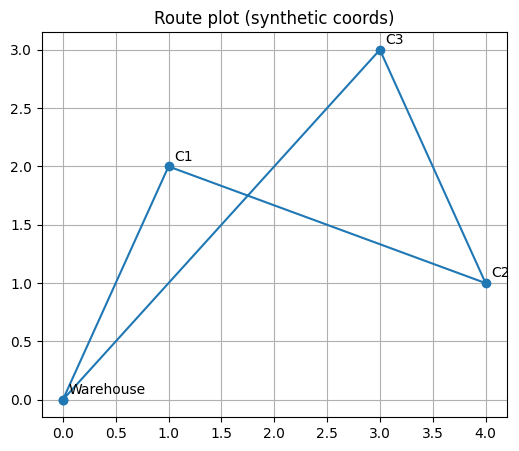

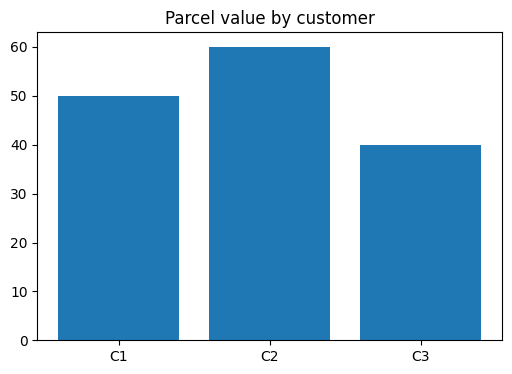

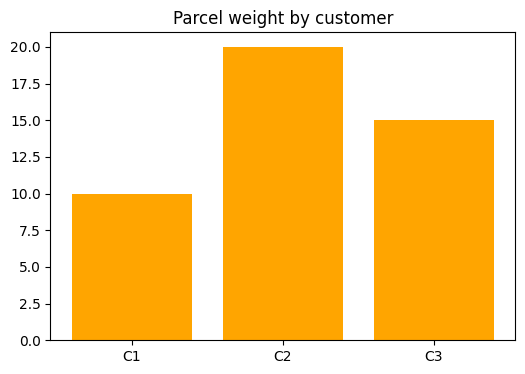

In [8]:

coords = {'Warehouse': (0,0), 'C1': (1,2), 'C2': (4,1), 'C3': (3,3)}
def plot_route(route):
    xs = [coords[node][0] for node in route]; ys = [coords[node][1] for node in route]
    plt.figure(figsize=(6,5)); plt.plot(xs, ys, '-o');
    for node in set(route): plt.text(coords[node][0]+0.05, coords[node][1]+0.05, node)
    plt.title("Route plot (synthetic coords)"); plt.grid(True); plt.show()

plot_route(route_bf)
names = list(parcels.keys())
values = [parcels[n]['value'] for n in names]; weights = [parcels[n]['weight'] for n in names]
plt.figure(figsize=(6,4)); plt.bar(names, values); plt.title("Parcel value by customer"); plt.show()
plt.figure(figsize=(6,4)); plt.bar(names, weights, color='orange'); plt.title("Parcel weight by customer"); plt.show()


n=3, avg_time=0.0000s
n=4, avg_time=0.0000s
n=5, avg_time=0.0000s
n=6, avg_time=0.0001s
n=7, avg_time=0.0011s
n=8, avg_time=0.0052s


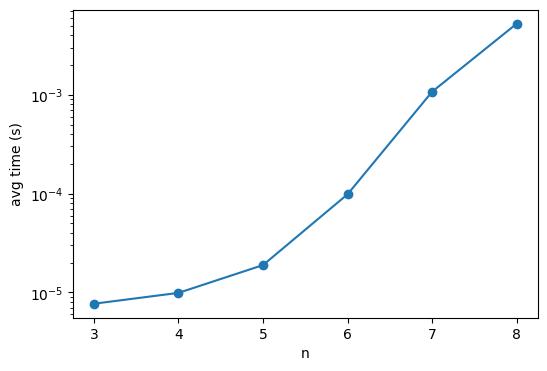

In [9]:

import time, random
def profile_tsp_bruteforce(max_n=8, trials=3):
    results = []
    base_locations = ['Warehouse'] + [f'C{i}' for i in range(1, max_n)]
    for n in range(3, max_n+1):
        times = []
        for t in range(trials):
            locs = base_locations[:n]
            mat = [[0]*n for _ in range(n)]
            for i in range(n):
                for j in range(i+1, n):
                    mat[i][j] = mat[j][i] = random.randint(1,10)
            start = time.perf_counter(); _ = tsp_bruteforce(locs, mat); dur = time.perf_counter()-start
            times.append(dur)
        avg = sum(times)/len(times); print(f"n={n}, avg_time={avg:.4f}s"); results.append((n, avg))
    return results

profile_results = profile_tsp_bruteforce(8, trials=3)
ns = [r[0] for r in profile_results]; ts = [r[1] for r in profile_results]
plt.figure(figsize=(6,4)); plt.plot(ns, ts, marker='o'); plt.xlabel('n'); plt.ylabel('avg time (s)'); plt.yscale('log'); plt.show()
